In this example, we will use the multicell module to simulate the self-organization of a geometrical Turing pattern (Turing 1952; Note about other proposals and ways to produce spatial patterns), based on equations developed by Gierer and Meinhardt (Gierer and Meinhardt 1972). These equations describe a simple molecular mechanism that involves two chemical species, an activator and a repressor. The activator activates itself, as well as the repressor. The repressor represses the activator. Both species are diffusible. The activator diffuses within a short-range, while the repressor diffuses within a longer range.
 
Despite its simplicity, this mechanism has been successfully used to explain the formation of many different molecular spatial patterns in tissue structures (Meinhardt and Gierer 1974; Meinhardt book 1982; Kondo 2010;). In this section, we will implement the Gierer-Meinhardt equations (Gierer and Meinhardt 1972).

# Preparation

In [1]:
%matplotlib notebook

# Imports

In [2]:
import multicell
import numpy as np

# Problem definition

## Simulation and tissue structure

In [3]:
sim = multicell.simulation_builder.generate_cell_grid_sim(20, 20, 1, 1e-3)

Topomesh importation: started
- setting mesh
- setting pos
- updating properties
Topomesh importation: finished (0.49 s)


## Biological species

We register two species: an activator `a` and an inhibitor `h`.

In [4]:
sim.register_cell_variable("a")
sim.register_cell_variable("h")

## Computed variables

The concentrations of `a` will be computed automatically for all cells. However, we will be going to use their squares multiple times per time step. To avoid raising the vector `c_a` to the square multiple times, we define a computed variable `c_a2` that will be computed once per time step. The equation of `c_a2` is defined using a Python function, which is then registered using the method `register_computed_variable` of the Simulation object.

In [5]:
def c_a2(c_a, **kwargs):
    return c_a**2

sim.register_computed_variable("c_a2", c_a2)

## Constants

In [6]:
sim.set_constants({"mu_a": 1e-1, "mu_h": 2e-1, "rho_a": 1., "rho_h": 1., "q": 1., "H": 0.35, "A": 0., "D_h": 5., "D_a": 0.025})

## Differential equations

The formula of da/dt is comprised of 4 additive terms: a diffusion term, an `a` and `h`-dependent synthesis term, a degradation term and a basal synthesis term.

In [7]:
def da_dt(simulation, a, c_a, c_a2, c_h, D_a, mu_a, rho_a, A, q, adjacency_matrix, **kwargs):
    return simulation.diffusion(D_a, c_a, adjacency_matrix) + rho_a * c_a2 / c_h / (1 + q**2 * c_a2) - mu_a * a + A

The formula of h is similarly built, except for the fact that the variable synthesis term is only `a`-dependent.

In [8]:
def dh_dt(simulation, h, c_a2, c_h, D_h, mu_h, rho_h, H, adjacency_matrix, **kwargs):
    return simulation.diffusion(D_h, c_h, adjacency_matrix) + rho_h * c_a2 - mu_h * h + H

sim.set_ODE("a", da_dt)
sim.set_ODE("h", dh_dt)

## Initial conditions

In [9]:
sim.initialize_cell_variables()

For Gierer-Meinhardt equations, initial values are important, as they influence the resulting steady state. We picked the ranges of initial concentrations so that some cells would tend to evolve towards a high a, high h steady state, while others would tend to evolve towards a low a, low h steady state, if there was no diffusion (i.e. if cells were independent).

In [10]:
a0 = np.random.uniform(0.28, 0.31, sim.n_cells)
h0 = np.random.uniform(4.37, 4.43, sim.n_cells)

sim.set_cell_variable("a", a0)
sim.set_cell_variable("h", h0)

## Duration

In [11]:
sim.set_duration(1e7)

## Rendering

In [12]:
sim.register_renderer(multicell.rendering.MatplotlibRenderer, "c_a", {"max_cmap": 1.3})


# Visualization of the initial state

<IPython.core.display.Javascript object>


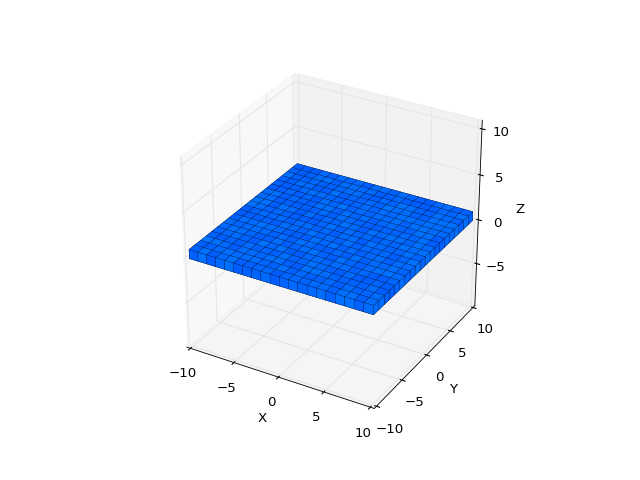

c_a: from 0.279841580118 to 0.31005242474
c_h: from 4.36791728692 to 4.43195429424


In [13]:
sim.renderer.display("c_a")

# Simulation

Jacobian computation: started
Jacobian computation: finished (0.02 s)
Integration of the ODE system: 19.1396501064 seconds


<IPython.core.display.Javascript object>


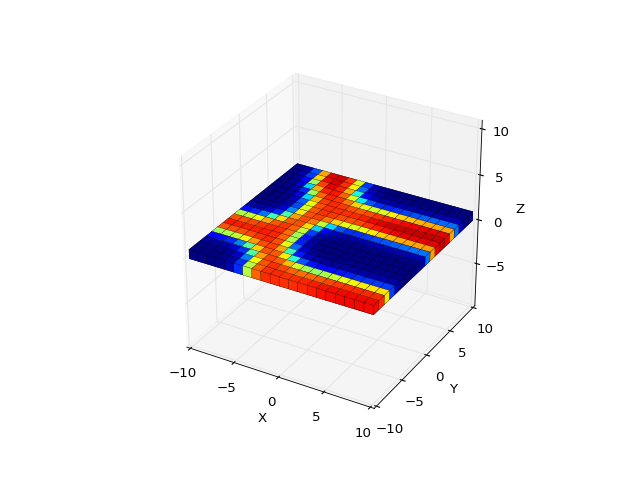

c_a: from 0.000728930962766 to 1.22267160508
c_h: from 3.68811071655 to 4.92507084264


In [14]:
sim.simulate()